# <font color='White'>Table of contents<font><a class='anchor' id='top'></a>
- [Pre Processing](#1)
- [Question 1 - PCA](#2)
- [Question 2 - Reconstructed Images](#3)
- [Question 3 - Scatter Plot of Rock Images](#4)
- [Question 4 - Comparing to Human Data](#4)
- [Question 5 - Kmeans Clustering](#6)
- [Question 6 - Expectation Maximization](#7)
- [Question 7 - Convulutional Neural Network](#8)

#### Imports

In [1]:

# Data Processing
import numpy as np
import pandas as pd

# ML models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

# Statistics
from scipy.spatial import procrustes
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, ImageOps
import os
import cv2

# misc
import time
import warnings
warnings.filterwarnings("ignore")

#### Nice Visualizations

In [2]:

plt.rc('font', family='Serif', size=12)
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#### Global Variables and file paths

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

RANDOM_STATE = 99
COLOR_MAP = plt.cm.twilight
IMAGE_FOLDER = "/kaggle/input/assignment-data/Data/Rock_Images"
VALIDATION_FOLDER = "/kaggle/input/assignment-data/Data/Validation_Images"
HUMAN_PREDICTIVE_FEATURES = "/kaggle/input/assignment-data/Data/mds_360.txt"
HUMAN_PREDICTIVE_FEATURES_VALIDATION = "/kaggle/input/assignment-data/Data/mds_120.txt"

<a id="1"></a>
### Pre Processing
Load the rock images

In [4]:
def get_label_from_filename(filename):
    if filename.startswith('I'):
        return 'Igneous'
    elif filename.startswith('M'):
        return 'Metamorphic'
    else:
        return 'Sedimentary'

def load_images_to_dataframe(folder):
    data = []  # To store flattened image data
    filenames = []  # To store filenames
    labels = []  # To store labels

    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Process only .jpg files
            # Assign label
            label = get_label_from_filename(filename)
            labels.append(label)

            # Load and preprocess image
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = ImageOps.grayscale(img)
            img = img.resize((256, 256))
            img_array = np.array(img) / 255.0

            # Flatten and append data
            data.append(img_array.flatten())
            filenames.append(filename)

    # Create DataFrame with image data
    image_df = pd.DataFrame(data, columns=list(range(len(data[0]))))

    # image_df['filename'] = filenames
    # image_df['label'] = labels

    return image_df, pd.Series(labels)

In [5]:
DATA, LABELS = load_images_to_dataframe(IMAGE_FOLDER)

rock_mapping = {"Igneous": 0, "Metamorphic": 1, "Sedimentary": 2}
encoded_labels = LABELS.map(rock_mapping)

Total Number of Rocks

In [6]:
len(DATA)

360

In [7]:
print(encoded_labels)

0      0
1      0
2      2
3      2
4      0
      ..
355    2
356    2
357    1
358    0
359    1
Length: 360, dtype: int64


The total number of features after converting to grayscale, resizing and flatenning image is 65536.

In [8]:
len(DATA.columns)

65536

In [9]:
print(DATA.shape)

(360, 65536)


In [10]:
DATA.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
1    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
2    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
3    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   
4    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  ...   

   65526  65527  65528  65529  65530  65531  65532  65533  65534  65535  
0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
1    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
2    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
3    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  
4    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  

[5 rows x 65536 columns]

<a id="1"></a>
### Pre Processing Details
The following preprocessing steps have been done over the images:
1. Converted to Grayscale
2. Resized to (256, 256)
3. Dividing the pixel values by 255.
4. Mapping the rock labels to integer values.

<a id="2"></a>
## Queston 1

In [11]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
print("Length of reduced vector to preserve 90% variance: ", len(X_reduced[0]))

Length of reduced vector to preserve 90% variance:  141


Number of components required to preserve 90% variance: 141


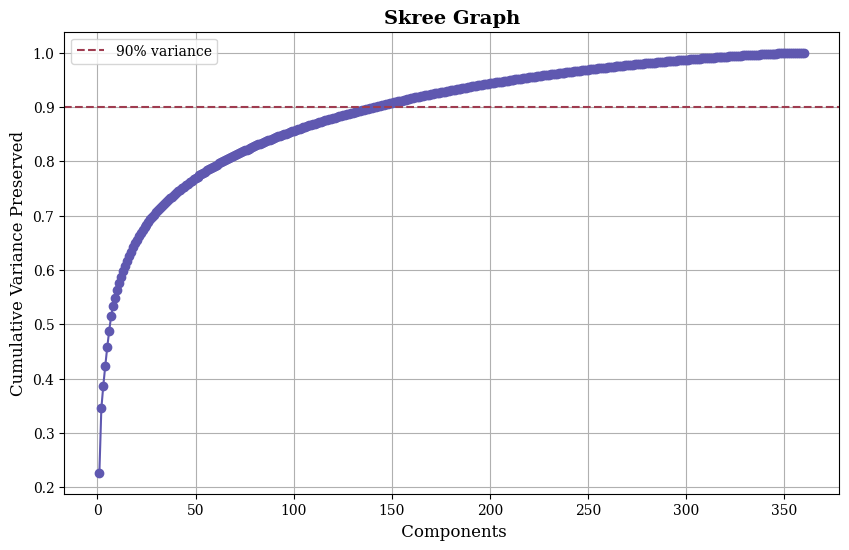

In [13]:
# Getting cumulative variance preserved for every feature included in the PCA.
line_color = COLOR_MAP(.3)
hline_color = COLOR_MAP(.7)

pca = PCA(svd_solver = "full")
pca.fit(DATA)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Number of components required to preserve 90% variance: {n_components_90}")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color=line_color)
plt.xlabel(' Components')
plt.ylabel('Cumulative Variance Preserved')
plt.title('Skree Graph')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% variance", c=hline_color)
plt.legend()
plt.grid(True)
plt.show()

<a id="2"></a>
## Answer 1
1. PCA has been applied to the data.
2. 141 components are required to capture 90% of the variance in the data.

<a id="3"></a>
## Question 2

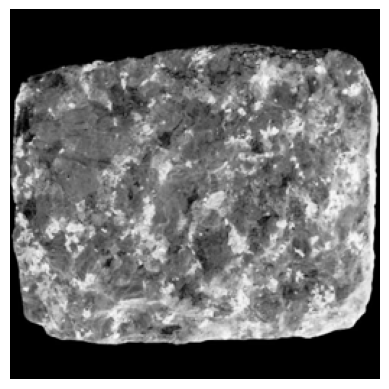

In [14]:
plt.imshow(np.array(DATA.iloc[0, : ]).reshape((256, 256)), cmap = 'Greys')
plt.axis('off')
plt.show()

In [15]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

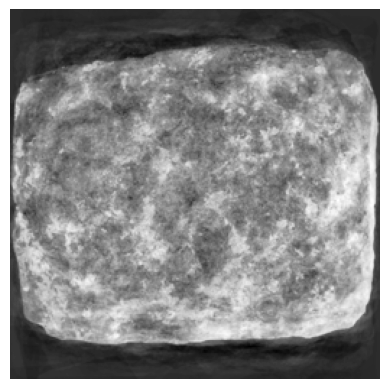

In [16]:
plt.imshow(X_recovered[0].reshape((256, 256)), cmap = "Greys")
plt.axis('off')
plt.show()

<Figure size 1000x1500 with 0 Axes>

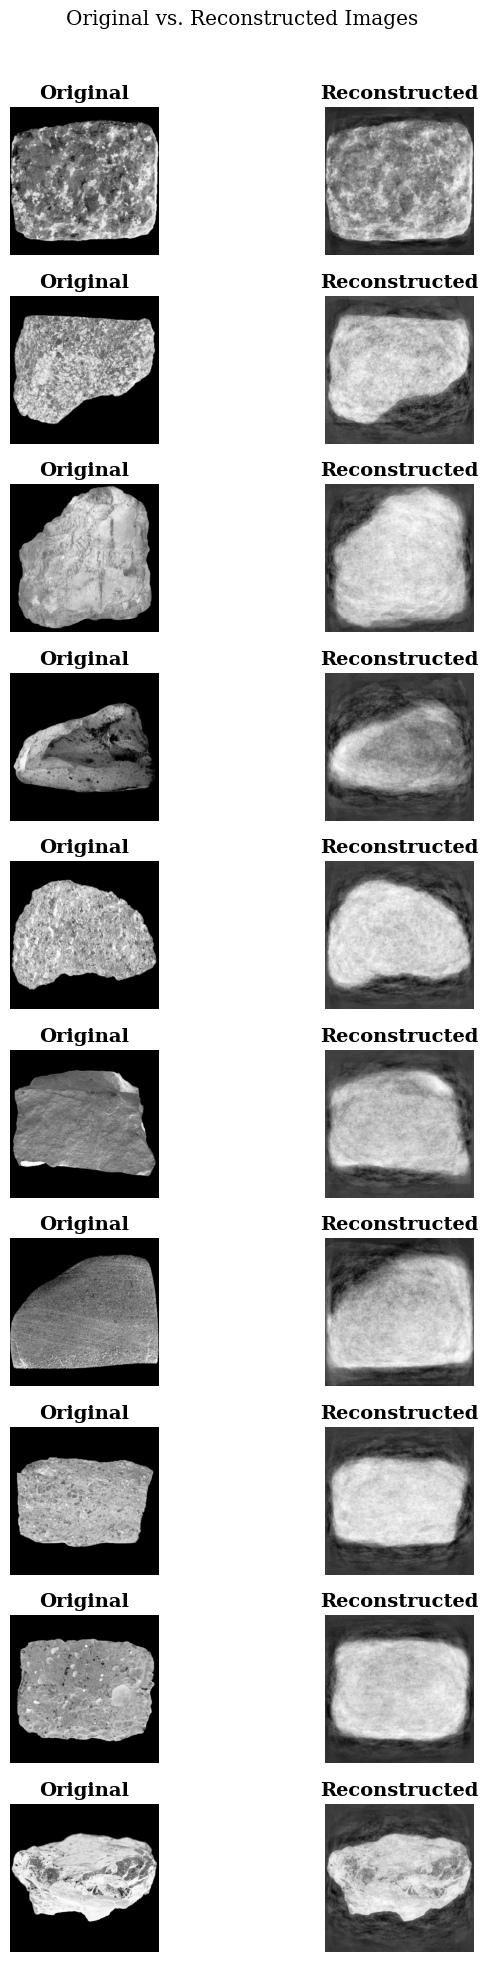

In [17]:
# Plotting the images pre and post reconstruction side by side:

num_images = 10
sample_indices = range(num_images)

plt.figure(figsize = (10, 15))

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i, idx in enumerate(sample_indices):
    axes[i, 0].imshow(np.array(DATA.iloc[idx, : ]).reshape((256, 256)), cmap='Greys')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_recovered[idx].reshape((256, 256)), cmap='Greys')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.suptitle("Original vs. Reconstructed Images")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<a id="4"></a>
## Answer
1. Original and Reconstructed images have been plotted.

<a id="4"></a>
## Question 3

#### 3.A

In [18]:
pca_two = PCA(n_components = 2)
X_reduced_two = pca_two.fit_transform(DATA)
X_recovered_two = pca_two.inverse_transform(X_reduced_two)

In [19]:
pca_two.explained_variance_ratio_

array([0.22656558, 0.11828768])

In [20]:
print("Total variance explained by the first two components: {0}%".format(sum(pca_two.explained_variance_ratio_) * 100))

Total variance explained by the first two components: 34.485326719873214%


In [21]:
plot_data = pd.DataFrame(columns = ["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_two)):
  curr_row = [X_reduced_two[itr][0], X_reduced_two[itr][1], LABELS[itr]]
  plot_data.loc[len(plot_data)] = curr_row

In [22]:
plot_data

PC1        PC2        Label
0     7.123492 -29.280801      Igneous
1    -3.001944  -1.072161      Igneous
2    17.026849 -21.458015  Sedimentary
3   -51.374545 -13.971027  Sedimentary
4    -2.630438   7.119230      Igneous
..         ...        ...          ...
355  11.428866  37.024257  Sedimentary
356 -10.897358  27.254740  Sedimentary
357 -58.426701 -29.189459  Metamorphic
358  35.782668 -16.196399      Igneous
359   8.638412  -5.279535  Metamorphic

[360 rows x 3 columns]

#### 3.B

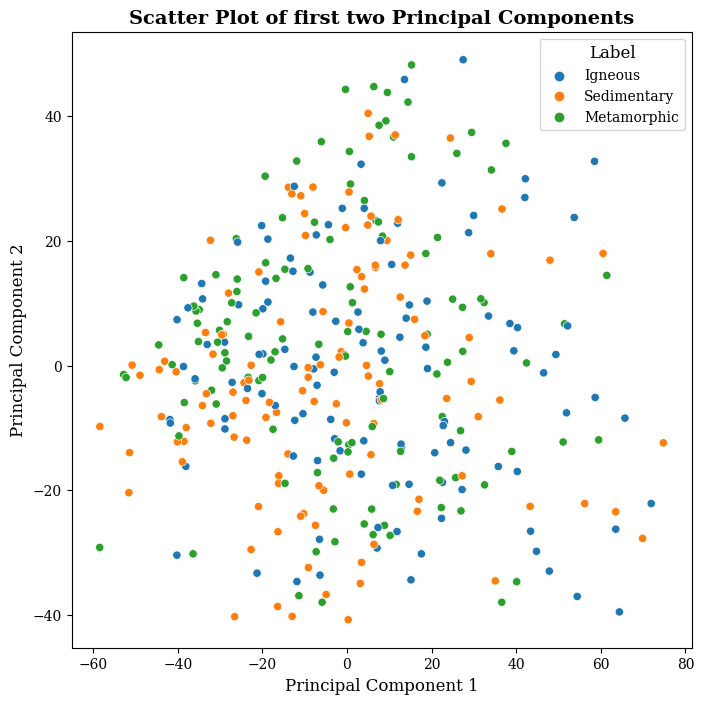

In [23]:
plt.figure(figsize = (8, 8))

sns.scatterplot(data = plot_data, x = 'PC1', y = 'PC2', hue = 'Label')

plt.title('Scatter Plot of first two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10), method=None):

    X_normalized = MinMaxScaler().fit_transform(X)

    neighbors = np.array([[10., 10.]])

    plt.figure(figsize=figsize)
    plt.title(method)
    plt.legend()

    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[COLOR_MAP(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=COLOR_MAP(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = np.array(images.iloc[index, : ]).reshape((256, 256))
                image = cv2.resize(image, (28, 28))
                imagebox = AnnotationBbox(OffsetImage(image, cmap='Greys'),
                                          image_coord, frameon=False, arrowprops=dict(arrowstyle="->"))
                ax.add_artist(imagebox)


def plot_principle_components(Reduced_X, method):
    print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

    plot_data = pd.DataFrame(
        {
            "PC1": Reduced_X[:, 0],
            "PC2": Reduced_X[:, 1],
            "Label": LABELS
        }
    )

    plot_digits(
        plot_data[["PC1", "PC2"]],
        encoded_labels,
        images=DATA,
        figsize=(10, 10),
        method = method
    )

Total variance explained by the first two components:  0.3448532671987312


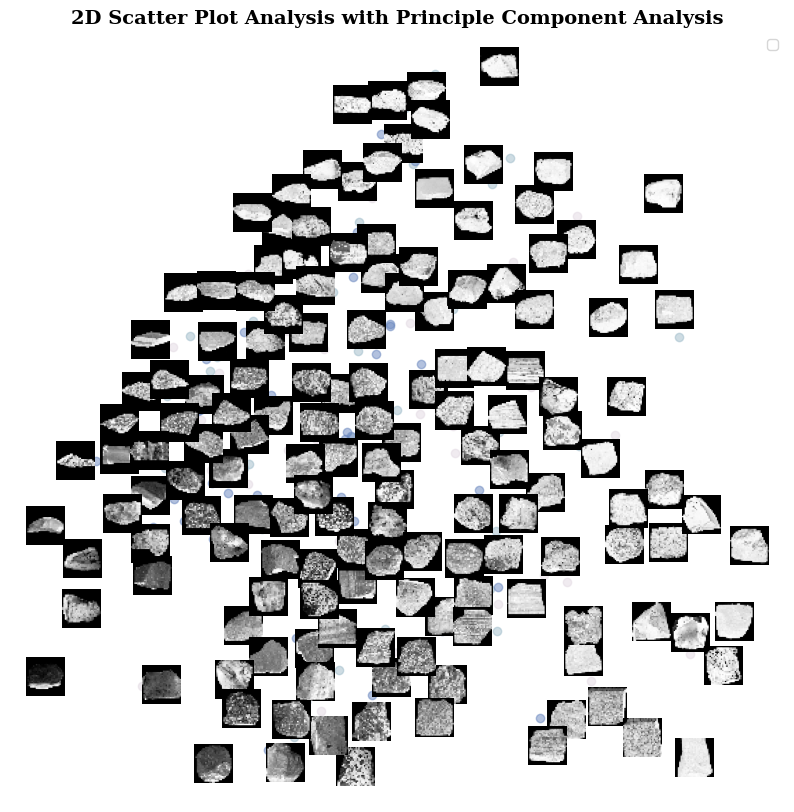

In [25]:
pca_two = PCA(n_components = 2)
Reduced_X = pca_two.fit_transform(DATA)
method = '2D Scatter Plot Analysis with Principle Component Analysis'
plot_principle_components(Reduced_X, method)

Total variance explained by the first two components:  0.3448532671987312


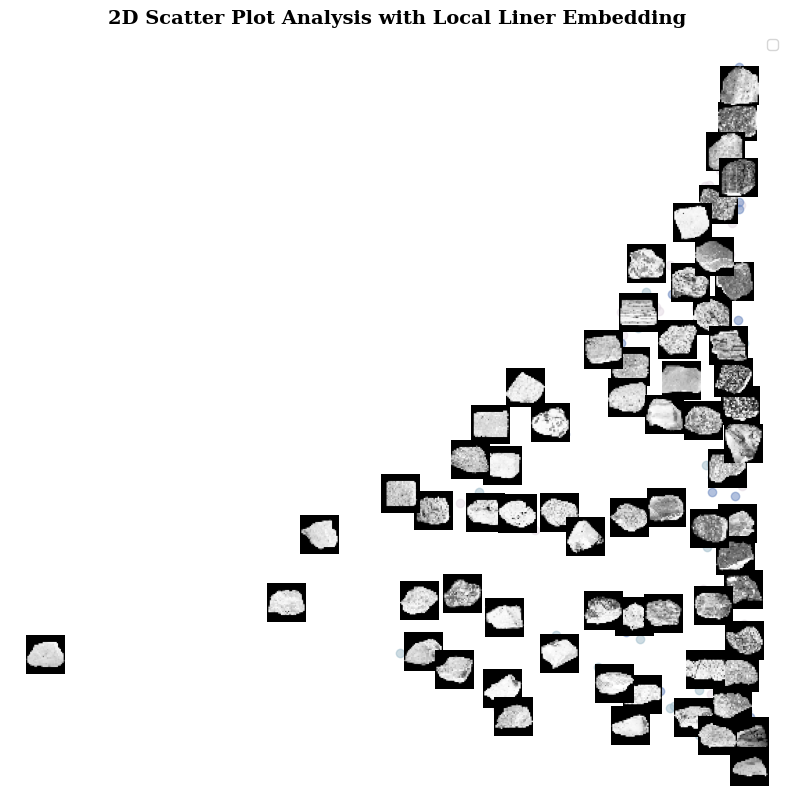

In [26]:

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5)
Reduced_X = lle.fit_transform(DATA)
method = '2D Scatter Plot Analysis with Local Liner Embedding'
plot_principle_components(Reduced_X, method)

Total variance explained by the first two components:  0.344853267198732


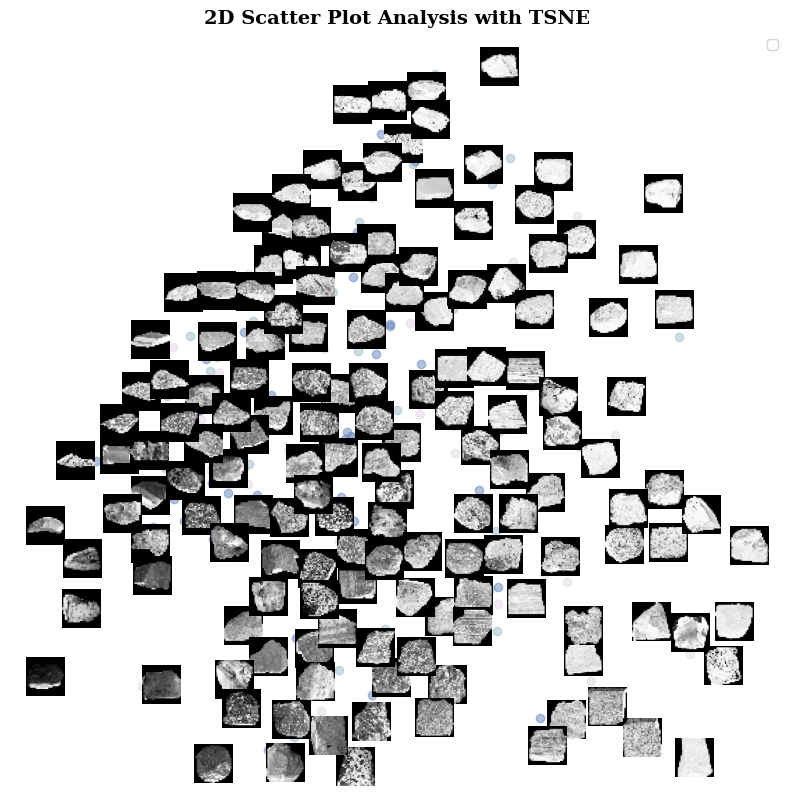

In [27]:

tsne = TSNE(n_components=2, perplexity=1, random_state=0)
Reduced_X = pca_two.fit_transform(DATA)
method = '2D Scatter Plot Analysis with TSNE'
plot_principle_components(Reduced_X, method)

Total variance explained by the first two components:  0.344853267198732


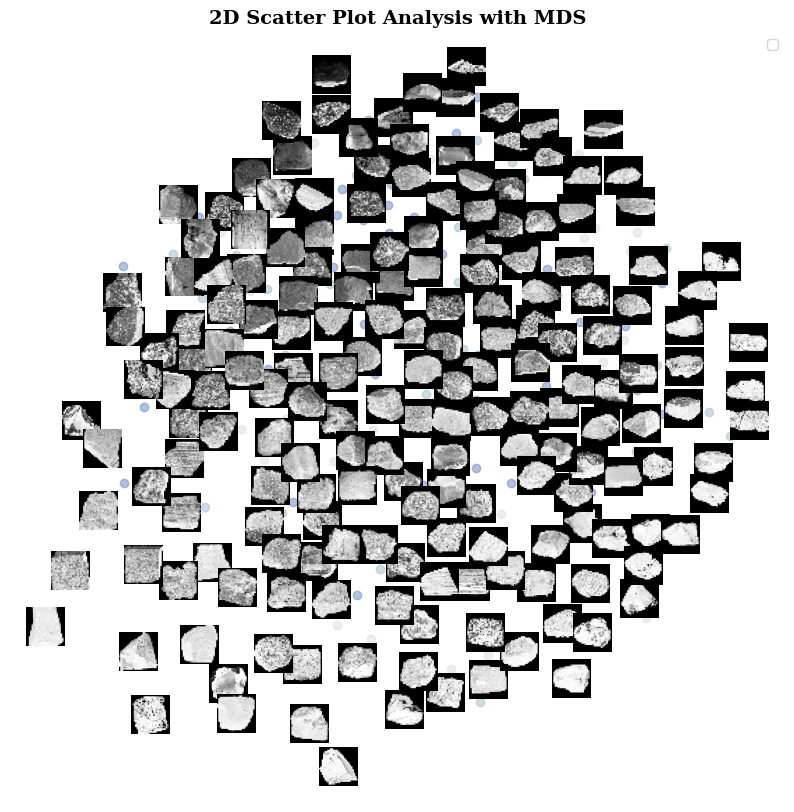

In [28]:

mds = MDS(n_components=2, random_state=0)
Reduced_X = mds.fit_transform(DATA)
method = '2D Scatter Plot Analysis with MDS'
plot_principle_components(Reduced_X, method)

<a id="5"></a>
## Answer
3A:
  1. Total variance explained by the first two principal components: 34.48532671987328%

3B:
  1. 5 2D scatter plots have been built:

    a. First 2 components using PCA.

    b. Scatter Plots with first two components with images for PCA, LLE, TSNE and MDS

3C: Discussion over plots:

  1. In all the plots, there does not seem to be a clear distinguishing boundary between the 3 types of rock categories.

  2. One of the main reasons for this can be the information loss when we reduce the images to only 2 dimensions.

  3. For PCA and TSNE, the darker shade rocks seem to be on the left side of the chart while the lighter shades are on the right side. For MDS, this is completely opposite with the lighter ones found on the left and the darker ones on the right.

  4. For LLE, there does not seem to be a great degree of separation between the shades of the images.

  5. For MDS, there is more compactness between the similar looking images i.e. the dark and light shade rocks are tightly packed closer than seen in other transformations.

  6. The plots show that there is no distinct boundary between the three different types of rocks based on the first two components. This can mean that the rock categories gradually transition from one type to other, which is actually the case as igneous rocks transform into metamorphic and then sedimentary rocks.

<a id="5"></a>
## Question 4

In [29]:
matrix_with_human_data = np.loadtxt(HUMAN_PREDICTIVE_FEATURES)
print(matrix_with_human_data)
print("Shape of Most important features for humans", matrix_with_human_data.shape)


procrustes_analysis = []

[[-3.743 -1.204  2.001 ... -1.992  4.95   1.695]
 [ 2.332  1.625  0.985 ...  0.093  6.724  0.708]
 [ 0.346  1.49  -3.795 ... -3.786  0.706 -2.854]
 ...
 [-3.475 -3.431 -2.184 ... -2.265  1.129 -1.201]
 [-0.051 -2.358  1.994 ...  7.268 -0.593 -1.432]
 [ 1.134 -4.9    0.983 ...  4.695  0.624 -1.195]]
Shape of Most important features for humans (360, 8)


#### PCA

In [30]:
mds = PCA(n_components=8, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

pca_result = {
        'Embedding': 'PCA',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: PCA')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: PCA
Disparity: 0.9903066734529975
Correlation: 0.09845469286429505
P_value: 1.1953461896430938e-07


In [31]:
pca_corr_table = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  pca_corr_table.loc[len(pca_corr_table)] = curr_row

pca_corr_table = pca_corr_table.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(pca_corr_table)

     Dimension  Correlation
0  Dimension 1     0.140161
1  Dimension 7     0.116476
2  Dimension 8     0.109885
3  Dimension 2     0.104116
4  Dimension 3     0.095783
5  Dimension 4     0.085307
6  Dimension 5     0.071380
7  Dimension 6     0.070697


#### LLE

In [32]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=10)
matrix_with_lle_embeddings_data = lle.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_lle_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

lle_result = {
        'Embedding': 'LLE',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(lle_result)

print('Embedding: LLE')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: LLE
Disparity: 0.986906780024853
Correlation: 0.11442560891315894
P_value: 7.353328056719625e-10


In [33]:
lle_corr_table = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  lle_corr_table.loc[len(lle_corr_table)] = curr_row

lle_corr_table = lle_corr_table.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(lle_corr_table)

     Dimension  Correlation
0  Dimension 7     0.160246
1  Dimension 2     0.153362
2  Dimension 8     0.146734
3  Dimension 1     0.131666
4  Dimension 3     0.101799
5  Dimension 5     0.096488
6  Dimension 4     0.085606
7  Dimension 6     0.059822


#### MDS

In [34]:
mds = MDS(n_components=8, random_state=RANDOM_STATE)
matrix_with_mds_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_mds_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

mds_result = {
        'Embedding': 'MDS',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(mds_result)

print('Embedding: MDS')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: MDS
Disparity: 0.9888007069481013
Correlation: 0.1058267123740448
P_value: 1.2498480972715074e-08


In [35]:
mds_corr_table = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  mds_corr_table.loc[len(mds_corr_table)] = curr_row

mds_corr_table = mds_corr_table.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(mds_corr_table)

     Dimension  Correlation
0  Dimension 1     0.181589
1  Dimension 5     0.120547
2  Dimension 7     0.118565
3  Dimension 2     0.104490
4  Dimension 8     0.096400
5  Dimension 4     0.087505
6  Dimension 3     0.080163
7  Dimension 6     0.056289


In [36]:
human_comparison_df = pd.DataFrame(procrustes_analysis).sort_values(by='Disparity')
display(human_comparison_df)

Embedding  Disparity  Correlation       P_Value
1       LLE   0.986907     0.114426  7.353328e-10
2       MDS   0.988801     0.105827  1.249848e-08
0       PCA   0.990307     0.098455  1.195346e-07

<a id="6"></a>
## Answer

1. The Procrustes analysis has been done over the PCA, MDS and LLE transformations. Out of which, the LLE has the least disparity meaning that it is the most similar one out of the three to the human data.

2. The 3 diparity values are very similar to each other but far from the ideal 0(no disprity) value.

3. The correlation for each dimension for the 3 transformations has been tabulated in the above cells.

<a id="6"></a>
## Question 5
Cluster the 360 images using K-Means

In [37]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init="auto")
kmeans.fit_predict(matrix_with_pca_embeddings_data)
silhouette_avg = silhouette_score(DATA, kmeans.labels_)
print(silhouette_avg)

0.07358794064774253


In [38]:

stat, p_value = pearsonr(encoded_labels, kmeans.labels_)
print(stat)

0.12171630256679136


In [39]:
silhouette_scores = []
cluster_range = range(2, 25)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
    cluster_labels = kmeans.fit_predict(matrix_with_pca_embeddings_data)
    score = silhouette_score(matrix_with_pca_embeddings_data, cluster_labels)
    silhouette_scores.append(score)

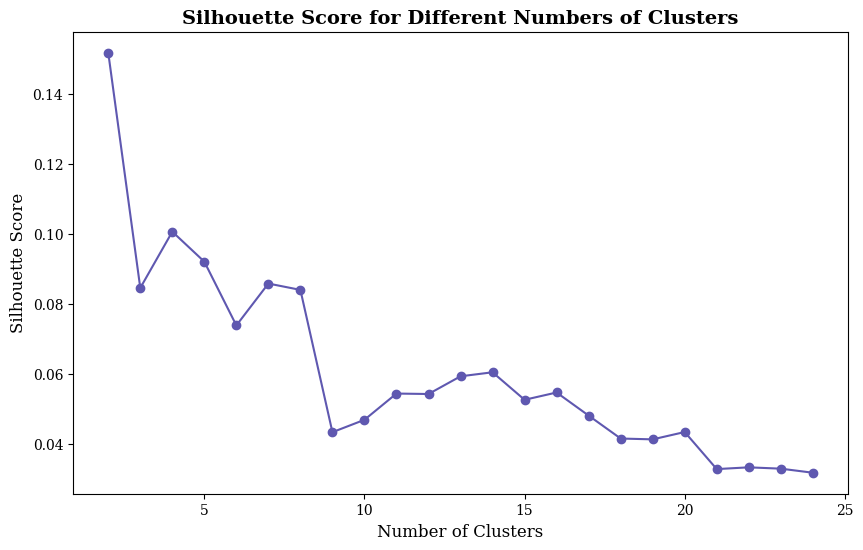

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color=line_color)
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Optimal number of clusters from the graph: 6

In [41]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init="auto")
kmeans.fit_predict(matrix_with_pca_embeddings_data)

kmeans.labels_

array([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 1, 0,
       0, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 1,
       2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2,
       0, 0, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1,
       1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 0,
       2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1,
       0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2,
       0, 1, 2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0,
       0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0,

In [42]:
acc_score = accuracy_score(encoded_labels, kmeans.labels_)
print("Accuracy of KMeans clustering with PCA and number of clusters as 3: {0}".format(acc_score))

Accuracy of KMeans clustering with PCA and number of clusters as 3: 0.34444444444444444


<a id="7"></a>
## Answer
1. PCA has been used to reduce the number of dimensions preserving 90% of the variance.

2. Silhouette Score has been used to determine the number of optimum clusters. The analysis reveals that 6 is the number of optimal clusters in the dataset.

3. Since there are only 3 categories of rocks, KMeans clustering has been performed using number of clusters as 3. The accuracy score thus obtained is 0.34444444444444444.

<a id="7"></a>
## Question 6

Cluster the 360 images using EM

In [43]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
gm = GaussianMixture(n_components=3, random_state=RANDOM_STATE)

predicted = gm.fit_predict(matrix_with_pca_embeddings_data)

In [44]:
stat, p_value = pearsonr(encoded_labels, predicted)
print(stat, p_value)

0.12171630256679136 0.02088994886753403


In [45]:
bic_scores = []
aic_scores = []

for n_components in cluster_range:
    gm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
    gm.fit(matrix_with_pca_embeddings_data)
    bic_scores.append(gm.bic(matrix_with_pca_embeddings_data))
    aic_scores.append(gm.aic(matrix_with_pca_embeddings_data))

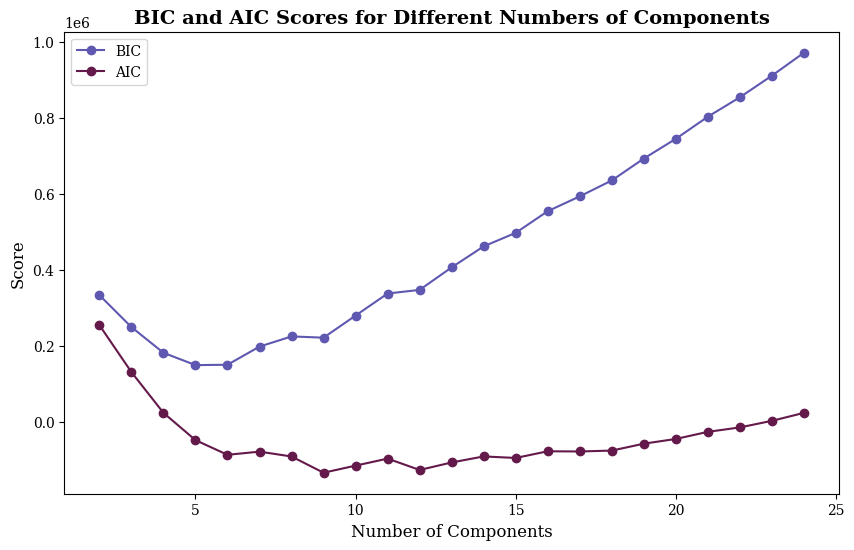

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, bic_scores, label='BIC', marker='o', color=COLOR_MAP(.3))
plt.plot(cluster_range, aic_scores, label='AIC', marker='o', color=COLOR_MAP(.6))
plt.title("BIC and AIC Scores for Different Numbers of Components")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()

Optimal number of clusters from the graph: 6

In [47]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
gm = GaussianMixture(n_components=3, random_state=RANDOM_STATE)

predicted = gm.fit_predict(matrix_with_pca_embeddings_data)

In [48]:
predicted

array([1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 1, 0,
       0, 2, 0, 1, 0, 1, 2, 2, 2, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 1,
       2, 2, 1, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 0, 2, 1, 0, 2,
       2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 2,
       0, 0, 1, 1, 2, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1,
       1, 2, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1, 2, 0, 0, 2, 1, 0, 2, 0,
       2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 1, 0, 2, 2, 0, 0, 2, 0,
       2, 0, 2, 1, 2, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 1,
       0, 1, 2, 0, 2, 0, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 2,
       0, 1, 2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 1, 0,
       0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 1, 2, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1,
       2, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0,

In [49]:
acc_score = accuracy_score(encoded_labels, predicted)
print("Accuracy of EM clustering with PCA and number of clusters as 3: {0}".format(acc_score))

Accuracy of EM clustering with PCA and number of clusters as 3: 0.34444444444444444


#### Sampling Images from the Gaussian Distributions

sampling 20 random rocks

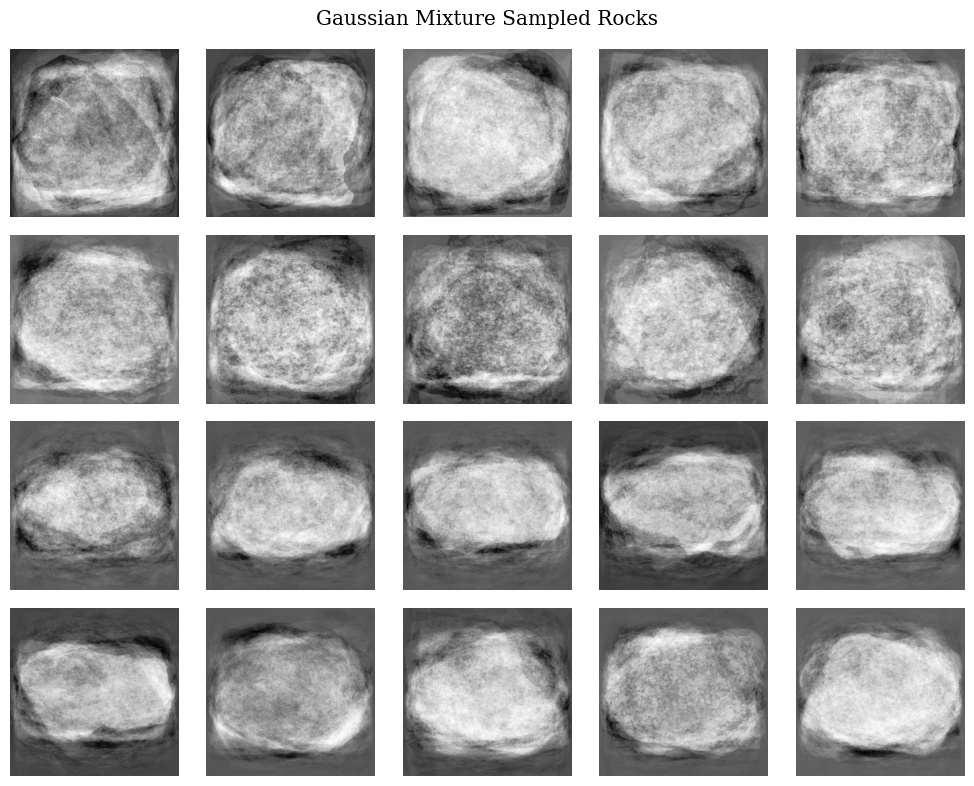

In [50]:
gm = GaussianMixture(n_components=6, random_state=RANDOM_STATE)
gm.fit(matrix_with_pca_embeddings_data)

samples, _ = gm.sample(n_samples=20)
original_space_samples = pca.inverse_transform(samples)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.array(original_space_samples[i, : ]).reshape((256, 256)), cmap = 'Greys')
    ax.axis('off')
plt.suptitle("Gaussian Mixture Sampled Rocks")
plt.tight_layout()
plt.show()

Sampling 2 rocks from each cluster

In [51]:
n_samples_per_cluster = 2
original_space_samples = []

for cluster_idx in range(gm.n_components):

    mean = gm.means_[cluster_idx]
    cov = gm.covariances_[cluster_idx]
    samples_from_cluster = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)

    original_space_samples.extend(pca.inverse_transform(samples_from_cluster))

original_space_samples = np.array(original_space_samples)

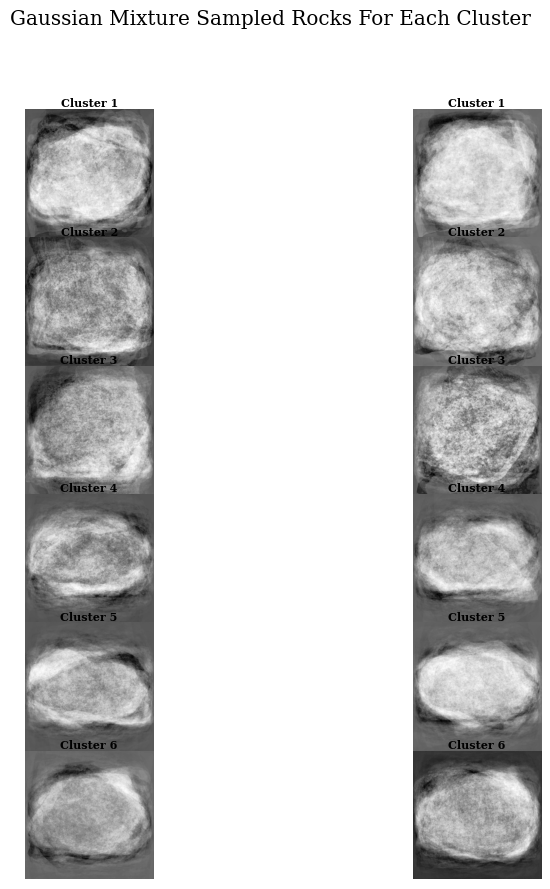

In [52]:
fig, axes = plt.subplots(gm.n_components, n_samples_per_cluster, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    cluster_label = i // n_samples_per_cluster
    ax.imshow(np.array(original_space_samples[i, :]).reshape((256, 256)), cmap='Greys')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster_label+1}", fontsize=8, pad=2)

plt.suptitle("Gaussian Mixture Sampled Rocks For Each Cluster")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<a id="8"></a>
## Answer

1. PCA has been used to reduce the number of dimensions preserving 90% of the variance.

2. AIC and BIC have been used to determine the number of optimum clusters. The analysis reveals that 6 is the number of optimal clusters in the dataset, same as Slihoutte score.

3. Since there are only 3 categories of rocks, EM clustering has been performed using number of clusters as 3. The accuracy score thus obtained is 0.34444444444444444, which is exactly the same as KMeans accuracy.

4. 20 random rock images have been generated and visualized in the baove cells.

<a id="8"></a>
## Question 7

In [53]:
# !pip install torchinfo

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

In [55]:

VALIDATION_DATA, VALIDATION_LABELS = load_images_to_dataframe(VALIDATION_FOLDER)

rock_mapping = {"Igneous": 0, "Metamorphic": 1, "Sedimentary": 2}
val_encoded_labels = VALIDATION_LABELS.map(rock_mapping)



#### Converting Data

In [56]:
features = DATA.values
val_features = VALIDATION_DATA.values

print(len(features))
print(len(encoded_labels))

print(len(val_features))
print(len(val_encoded_labels))

360
360
120
120


In [57]:
batch_size = 32

In [58]:

features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)

train_dataset = TensorDataset(features_tensor, labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [59]:
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_encoded_labels, dtype=torch.long)

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [60]:
print(f"Labels: {val_labels_tensor.unique()}")
print(f"Labels: {labels_tensor.unique()}")

Labels: tensor([0, 1, 2])
Labels: tensor([0, 1, 2])


In [61]:
print(val_dataset[0])

(tensor([1., 1., 1.,  ..., 1., 1., 1.]), tensor(1))


#### Building The Model

In [62]:
class RockClassifier(nn.Module):
    def __init__(self):
        super(RockClassifier, self).__init__()

        # Fully connected layers to process the flattened input
        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(8, 3)

    def forward(self, x):
        # Fully connected layers with ReLU
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.output_layer(x)
        return x



def train_model(model, Training_DataLoader, device, optimizer, criterion):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in Training_DataLoader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_total += labels.size(0)


    return train_correct/train_total, train_loss

def eval_model(model, Test_DataLoader, device, criterion):
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in Test_DataLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            test_correct+= (torch.argmax(outputs, dim=1) == labels).sum().item()
            test_total += labels.size(0)

    return test_correct/test_total, test_loss

In [63]:

model = RockClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RockClassifier(
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
)

#### 7.A
Report Training Time

In [64]:
%time train_model(model, train_dataloader, device, optimizer, criterion)

CPU times: user 954 ms, sys: 138 ms, total: 1.09 s
Wall time: 710 ms


(0.3333333333333333, 13.326364636421204)

#### 7.B
Plot training and validation lost as a function of training epochs

In [65]:
num_epochs = 100

In [66]:
import time
# Lists to store metrics for each epoch
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []
ist = time.time()

for epoch in range(num_epochs):
    st = time.time()
    print(f"Current Epoch: {epoch+1}")

    # Training
    train_accuracy, train_loss = train_model(model, train_dataloader, device, optimizer, criterion)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss)

    # Validation
    val_accuracy, val_loss = eval_model(model, val_dataloader, device, criterion)
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss)

    print("Metrics: Train Accuracy = {0}, Train Loss = {1}, Validation Accuracy = {2}, Validation Loss = {3}, Epoch Time = {4} seconds".format(train_accuracy, train_loss, val_accuracy, val_loss, time.time() - st))

print("Average Time per Epoch: {0} seconds".format((time.time() - ist) / num_epochs))


Current Epoch: 1
Metrics: Train Accuracy = 0.3333333333333333, Train Loss = 13.24045729637146, Validation Accuracy = 0.3333333333333333, Validation Loss = 4.413454055786133, Epoch Time = 0.394122838973999 seconds
Current Epoch: 2
Metrics: Train Accuracy = 0.3333333333333333, Train Loss = 13.213616251945496, Validation Accuracy = 0.3333333333333333, Validation Loss = 4.406772613525391, Epoch Time = 0.39191389083862305 seconds
Current Epoch: 3
Metrics: Train Accuracy = 0.30833333333333335, Train Loss = 13.208842635154724, Validation Accuracy = 0.3416666666666667, Validation Loss = 4.402699828147888, Epoch Time = 0.39893579483032227 seconds
Current Epoch: 4
Metrics: Train Accuracy = 0.35555555555555557, Train Loss = 13.140219569206238, Validation Accuracy = 0.325, Validation Loss = 4.400127649307251, Epoch Time = 0.3898129463195801 seconds
Current Epoch: 5
Metrics: Train Accuracy = 0.31666666666666665, Train Loss = 13.149726867675781, Validation Accuracy = 0.3, Validation Loss = 4.3978533

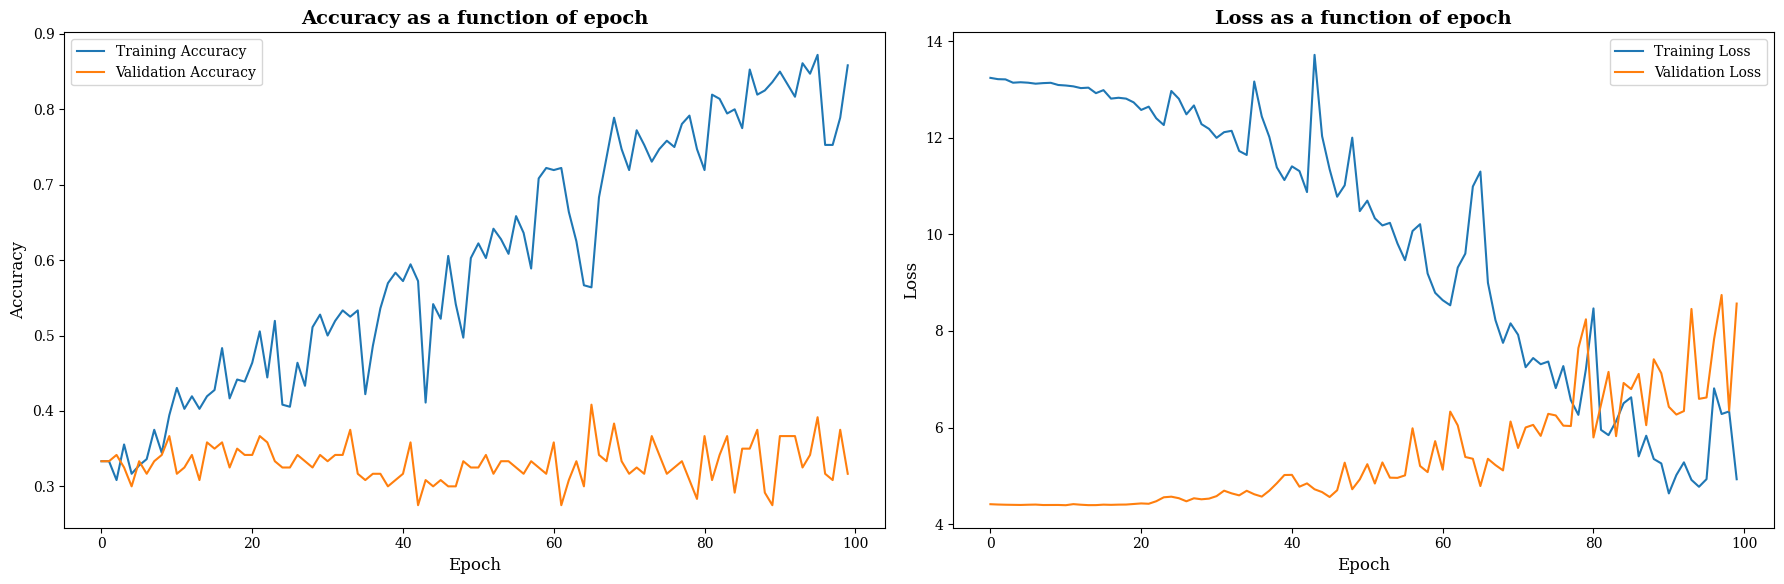

In [67]:
x = list(range(num_epochs))

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot accuracy
axs[0].plot(x, training_accuracy, label='Training Accuracy')
axs[0].plot(x, validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy as a function of epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(x, training_loss, label='Training Loss')
axs[1].plot(x, validation_loss, label='Validation Loss')
axs[1].set_title('Loss as a function of epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### 7.C

How many parameters does the network have? How many of those parameters are bias parameters?

Number of Weights and Biases per Layer

In [68]:
bias_parameters = 0

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer: {name} | Weights: {len(param.data)}")
    elif "bias" in name:
        print(f"Layer: {name} | Biases: {len(param.data)}")
        bias_parameters += len(param.data)

Layer: fc1.weight | Weights: 512
Layer: fc1.bias | Biases: 512
Layer: fc2.weight | Weights: 256
Layer: fc2.bias | Biases: 256
Layer: fc3.weight | Weights: 128
Layer: fc3.bias | Biases: 128
Layer: fc4.weight | Weights: 64
Layer: fc4.bias | Biases: 64
Layer: fc5.weight | Weights: 32
Layer: fc5.bias | Biases: 32
Layer: fc6.weight | Weights: 16
Layer: fc6.bias | Biases: 16
Layer: fc7.weight | Weights: 8
Layer: fc7.bias | Biases: 8
Layer: output_layer.weight | Weights: 3
Layer: output_layer.bias | Biases: 3


In [69]:
print("Total Number of Biases: {0}".format(bias_parameters))

Total Number of Biases: 1019


Neural Network Architecture

In [70]:

summary(model, input_size=(batch_size, 256*256))

Layer (type:depth-idx)                   Output Shape              Param #
RockClassifier                           [32, 3]                   --
├─Linear: 1-1                            [32, 512]                 33,554,944
├─ReLU: 1-2                              [32, 512]                 --
├─Linear: 1-3                            [32, 256]                 131,328
├─ReLU: 1-4                              [32, 256]                 --
├─Linear: 1-5                            [32, 128]                 32,896
├─ReLU: 1-6                              [32, 128]                 --
├─Linear: 1-7                            [32, 64]                  8,256
├─ReLU: 1-8                              [32, 64]                  --
├─Linear: 1-9                            [32, 32]                  2,080
├─ReLU: 1-10                             [32, 32]                  --
├─Linear: 1-11                           [32, 16]                  528
├─ReLU: 1-12                             [32, 16]            

In [71]:
print("Total number of parameters in the model: ", 33,730,195)
print("Total number of trainable parameters in the model: ", 33,730,195)
print("Total number of non-trainable parameters in the model: ", 0)
print("Total number of biases in the model: ", bias_parameters)

Total number of parameters in the model:  33 730 195
Total number of trainable parameters in the model:  33 730 195
Total number of non-trainable parameters in the model:  0
Total number of biases in the model:  1019


#### 7.D

In [72]:
for i in model.output_layer.weight:
    print(len(i))

8
8
8


In [73]:
model

RockClassifier(
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (fc7): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
)

In [74]:
torch.manual_seed(RANDOM_STATE)

all_outputs_train = []

model.eval()
for images, labels in train_dataloader:
    images = images.to(device)
    labels = labels.to(device)

    x = model.relu(model.fc1(images))
    x = model.relu(model.fc2(x))
    x = model.relu(model.fc3(x))
    x = model.relu(model.fc4(x))
    x = model.relu(model.fc5(x))
    x = model.relu(model.fc6(x))
    output_fc7 = model.relu(model.fc7(x))

    all_outputs_train.append(output_fc7.cpu())

all_outputs_train_combined = torch.cat(all_outputs_train, dim=0)

all_outputs_train_numpy = all_outputs_train_combined.detach().numpy()

print(all_outputs_train_numpy.shape)

(360, 8)


In [75]:
matrix_with_human_data

array([[-3.743, -1.204,  2.001, ..., -1.992,  4.95 ,  1.695],
       [ 2.332,  1.625,  0.985, ...,  0.093,  6.724,  0.708],
       [ 0.346,  1.49 , -3.795, ..., -3.786,  0.706, -2.854],
       ...,
       [-3.475, -3.431, -2.184, ..., -2.265,  1.129, -1.201],
       [-0.051, -2.358,  1.994, ...,  7.268, -0.593, -1.432],
       [ 1.134, -4.9  ,  0.983, ...,  4.695,  0.624, -1.195]])

In [76]:
all_outputs_train_numpy

array([[0.       , 2.074276 , 2.5947733, ..., 2.701891 , 7.348477 ,
        0.       ],
       [0.       , 2.8402746, 3.7883651, ..., 3.446808 , 6.5583143,
        0.       ],
       [0.       , 5.9693327, 1.6653625, ..., 7.3762884, 7.838596 ,
        0.       ],
       ...,
       [0.       , 3.877427 , 3.7903612, ..., 4.8101997, 8.080968 ,
        0.       ],
       [0.       , 3.7448452, 6.3102546, ..., 4.226236 , 5.4096375,
        0.       ],
       [0.       , 2.361446 , 2.7314305, ..., 3.0395548, 7.462207 ,
        0.       ]], dtype=float32)

In [77]:
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, all_outputs_train_numpy)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

nn_train_result = {
        'Embedding': 'Neural Network Train',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: Neural Network Train')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: Neural Network Train
Disparity: 0.9921825578267668
Correlation: 0.08841630038196205
P_value: 2.0124930187957532e-06


In [78]:
nn_corr_table_train = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  nn_corr_table_train.loc[len(nn_corr_table_train)] = curr_row

nn_corr_table_train = nn_corr_table_train.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(nn_corr_table_train)

     Dimension  Correlation
0  Dimension 2     0.123521
1  Dimension 5     0.118338
2  Dimension 4     0.117991
3  Dimension 6     0.086969
4  Dimension 7     0.071480
5  Dimension 8     0.071007
6  Dimension 3     0.065253
7  Dimension 1     0.049553


In [79]:
torch.manual_seed(RANDOM_STATE)

all_outputs_valid = []

model.eval()
for images, labels in val_dataloader:
    images = images.to(device)
    labels = labels.to(device)

    x = model.relu(model.fc1(images))
    x = model.relu(model.fc2(x))
    x = model.relu(model.fc3(x))
    x = model.relu(model.fc4(x))
    x = model.relu(model.fc5(x))
    x = model.relu(model.fc6(x))
    output_fc7 = model.relu(model.fc7(x))

    all_outputs_valid.append(output_fc7.cpu())

all_outputs_valid_combined = torch.cat(all_outputs_valid, dim=0)

all_outputs_valid_numpy = all_outputs_valid_combined.detach().numpy()

print(all_outputs_valid_numpy.shape)

(120, 8)


In [80]:
matrix_with_human_data_valid = np.loadtxt(HUMAN_PREDICTIVE_FEATURES_VALIDATION)

mtx1, mtx2, disparity = procrustes(matrix_with_human_data_valid, all_outputs_valid_numpy)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

nn_train_result = {
        'Embedding': 'Neural Network Validation',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: Neural Network Validation')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: Neural Network Validation
Disparity: 0.981745184034973
Correlation: 0.13511038437154615
P_value: 2.6684352771167693e-05


In [81]:
nn_corr_table_valid = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  nn_corr_table_valid.loc[len(nn_corr_table_valid)] = curr_row

nn_corr_table_valid = nn_corr_table_valid.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(nn_corr_table_valid)

     Dimension  Correlation
0  Dimension 6     0.202212
1  Dimension 5     0.175580
2  Dimension 7     0.173524
3  Dimension 3     0.153200
4  Dimension 8     0.135060
5  Dimension 4     0.113876
6  Dimension 2     0.100284
7  Dimension 1     0.047272


Trying out CNNs for a better classification

In [82]:
import torch
import torch.nn as nn

class RockClassifierCNN(nn.Module):
    def __init__(self):
        super(RockClassifierCNN, self).__init__()

        # Reversed order of convolutional layers
        self.conv1 = nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc_intermediate = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 3)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = self.relu(self.conv5(x))

        x = self.gap(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc_intermediate(x))
        x = self.output_layer(x)
        return x

def train_model(model, Training_DataLoader, device, optimizer, criterion):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0

    for images, labels in Training_DataLoader:

        images = images.view(-1, 1, 256, 256).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_total += labels.size(0)


    return train_correct / train_total, train_loss


def eval_model(model, Test_DataLoader, device, criterion):
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in Test_DataLoader:

            images = images.view(-1, 1, 256, 256).to(device)
            labels = labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            test_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            test_total += labels.size(0)

    return test_correct / test_total, test_loss


modelCNN = RockClassifierCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelCNN.to(device)

RockClassifierCNN(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc_intermediate): Linear(in_features=16, out_features=8, bias=True)
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)

In [83]:
%time train_model(modelCNN, train_dataloader, device, optimizer, criterion)

CPU times: user 11.9 s, sys: 206 ms, total: 12.1 s
Wall time: 9.91 s


(0.3333333333333333, 13.447508335113525)

In [84]:
import time
num_epochs = 100

training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []
ist = time.time()

for epoch in range(num_epochs):
    st = time.time()
    print(f"Current Epoch: {epoch+1}")

    train_accuracy, train_loss = train_model(modelCNN, train_dataloader, device, optimizer, criterion)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss)

    val_accuracy, val_loss = eval_model(modelCNN, val_dataloader, device, criterion)
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss)

    print("Metrics: Train Accuracy = {0}, Train Loss = {1}, Validation Accuracy = {2}, Validation Loss = {3}, Epoch Time = {4} seconds".format(train_accuracy, train_loss, val_accuracy, val_loss, time.time() - st))

print("Average Time per Epoch: {0} seconds".format((time.time() - ist) / num_epochs))

Current Epoch: 1
Metrics: Train Accuracy = 0.3333333333333333, Train Loss = 13.305363774299622, Validation Accuracy = 0.3333333333333333, Validation Loss = 4.416323781013489, Epoch Time = 10.234906911849976 seconds
Current Epoch: 2
Metrics: Train Accuracy = 0.33055555555555555, Train Loss = 13.253665566444397, Validation Accuracy = 0.38333333333333336, Validation Loss = 4.395143389701843, Epoch Time = 10.431756258010864 seconds
Current Epoch: 3
Metrics: Train Accuracy = 0.3, Train Loss = 13.305129528045654, Validation Accuracy = 0.3333333333333333, Validation Loss = 4.404491543769836, Epoch Time = 10.525374412536621 seconds
Current Epoch: 4
Metrics: Train Accuracy = 0.3333333333333333, Train Loss = 13.21405291557312, Validation Accuracy = 0.3333333333333333, Validation Loss = 4.402826309204102, Epoch Time = 10.612710237503052 seconds
Current Epoch: 5
Metrics: Train Accuracy = 0.32222222222222224, Train Loss = 13.189597606658936, Validation Accuracy = 0.3333333333333333, Validation Loss

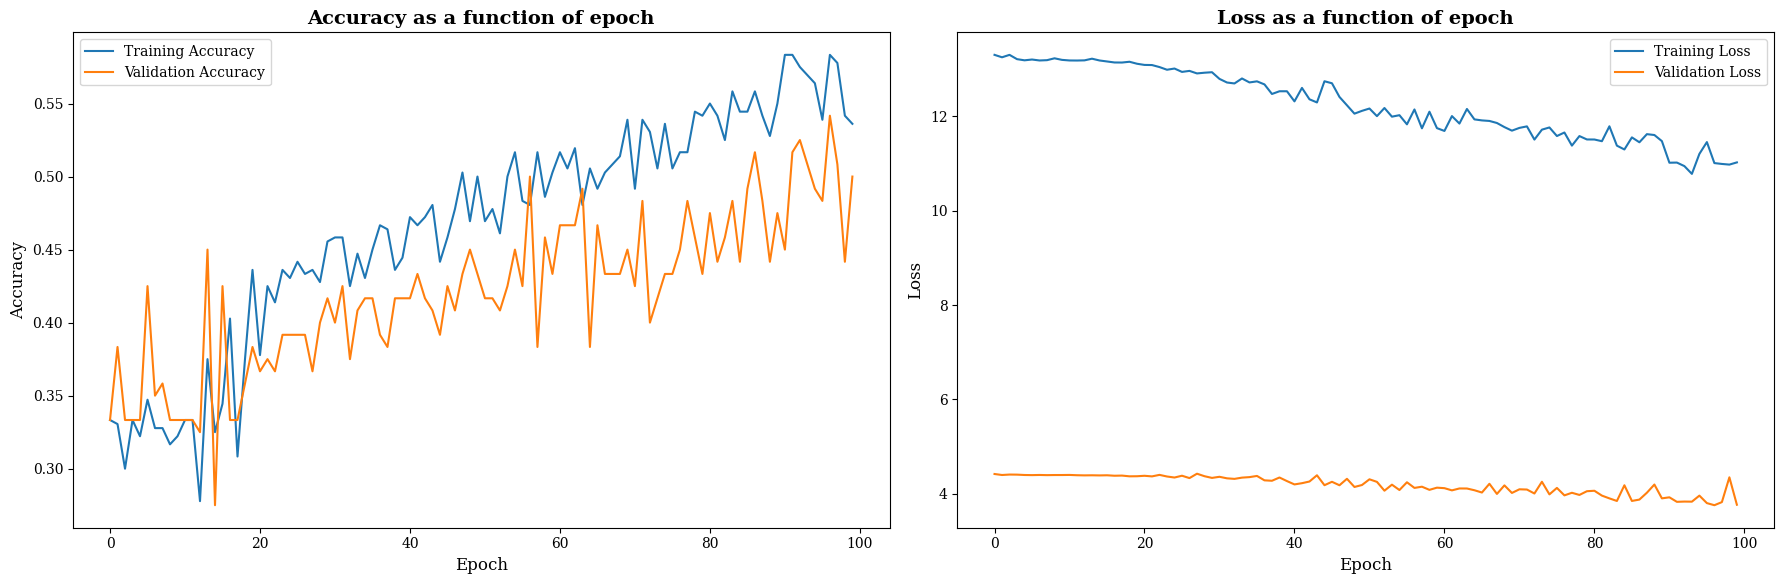

In [85]:
x = list(range(num_epochs))

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot accuracy
axs[0].plot(x, training_accuracy, label='Training Accuracy')
axs[0].plot(x, validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy as a function of epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(x, training_loss, label='Training Loss')
axs[1].plot(x, validation_loss, label='Validation Loss')
axs[1].set_title('Loss as a function of epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [86]:
bias_parameters = 0

for name, param in modelCNN.named_parameters():
    if "weight" in name:
        print(f"Layer: {name} | Weights: {len(param.data)}")
    elif "bias" in name:
        print(f"Layer: {name} | Biases: {len(param.data)}")
        bias_parameters += len(param.data)

print("Total Number of Biases: {0}".format(bias_parameters))

Layer: conv1.weight | Weights: 256
Layer: conv1.bias | Biases: 256
Layer: conv2.weight | Weights: 128
Layer: conv2.bias | Biases: 128
Layer: conv3.weight | Weights: 64
Layer: conv3.bias | Biases: 64
Layer: conv4.weight | Weights: 32
Layer: conv4.bias | Biases: 32
Layer: conv5.weight | Weights: 16
Layer: conv5.bias | Biases: 16
Layer: fc_intermediate.weight | Weights: 8
Layer: fc_intermediate.bias | Biases: 8
Layer: output_layer.weight | Weights: 3
Layer: output_layer.bias | Biases: 3
Total Number of Biases: 507


In [87]:
summary(modelCNN, (1, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
RockClassifierCNN                        [1, 3]                    --
├─Conv2d: 1-1                            [1, 256, 256, 256]        2,560
├─ReLU: 1-2                              [1, 256, 256, 256]        --
├─Conv2d: 1-3                            [1, 128, 256, 256]        295,040
├─ReLU: 1-4                              [1, 128, 256, 256]        --
├─MaxPool2d: 1-5                         [1, 128, 128, 128]        --
├─Conv2d: 1-6                            [1, 64, 128, 128]         73,792
├─ReLU: 1-7                              [1, 64, 128, 128]         --
├─MaxPool2d: 1-8                         [1, 64, 64, 64]           --
├─Conv2d: 1-9                            [1, 32, 64, 64]           18,464
├─ReLU: 1-10                             [1, 32, 64, 64]           --
├─MaxPool2d: 1-11                        [1, 32, 32, 32]           --
├─Conv2d: 1-12                           [1, 16, 32, 32]           4,

In [88]:
print("Total number of parameters in the CNN Model: ", 394,643)
print("Total number of trainable parameters in the CNN Model: ", 394,643)
print("Total number of non-trainable parameters in the CNN Model: ", 0)
print("Total number of biases in the CNN Model: ", bias_parameters)

Total number of parameters in the CNN Model:  394 643
Total number of trainable parameters in the CNN Model:  394 643
Total number of non-trainable parameters in the CNN Model:  0
Total number of biases in the CNN Model:  507


In [89]:
def extract_features_from_fc8(modelCNN, DataLoader, device):
    """
    Extract outputs from the fully connected layer with 8 nodes.
    
    Parameters:
    - modelCNN: The CNN model from which features are to be extracted.
    - DataLoader: DataLoader containing the data for which features are to be extracted.
    - device: Device (CPU or CUDA) to perform the operations on.
    
    Returns:
    - A numpy array of extracted features from the layer with 8 nodes.
    """
    modelCNN.eval()  # Set the model to evaluation mode
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculation
        for images, _ in DataLoader:  # Labels are not needed for feature extraction
            images = images.view(-1, 1, 256, 256).to(device)  # Reshape and move to device
            x = modelCNN.relu(modelCNN.conv1(images))
            x = modelCNN.pool(modelCNN.relu(modelCNN.conv2(x)))
            x = modelCNN.pool(modelCNN.relu(modelCNN.conv3(x)))
            x = modelCNN.pool(modelCNN.relu(modelCNN.conv4(x)))
            x = modelCNN.relu(modelCNN.conv5(x))

            x = modelCNN.gap(x)  # Global average pooling
            x = x.view(x.size(0), -1)  # Flatten the features

            output_fc8 = modelCNN.relu(modelCNN.fc_intermediate(x))  # Extract from the 8-node layer
            all_outputs.append(output_fc8.cpu())  # Collect outputs in CPU memory

    all_outputs_combined = torch.cat(all_outputs, dim=0)  # Combine all outputs
    return all_outputs_combined.numpy()  # Convert to numpy array

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)

features_train = extract_features_from_fc8(modelCNN, train_dataloader, device)
print("Extracted train features shape:", features_train.shape)

features_valid = extract_features_from_fc8(modelCNN, val_dataloader, device)
print("Extracted train features shape:", features_valid.shape)

Extracted train features shape: (360, 8)
Extracted train features shape: (120, 8)


In [90]:
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, features_train)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

nn_train_result = {
        'Embedding': 'CNN Train',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: CNN Train')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: CNN Train
Disparity: 0.9964810280058564
Correlation: 0.059320923746547544
P_value: 0.0014479517966393307


In [91]:
cnn_corr_table_train = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  cnn_corr_table_train.loc[len(cnn_corr_table_train)] = curr_row

cnn_corr_table_train = cnn_corr_table_train.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(cnn_corr_table_train)

     Dimension  Correlation
0  Dimension 1     0.095298
1  Dimension 5     0.064223
2  Dimension 6     0.054753
3  Dimension 4     0.049278
4  Dimension 7     0.048033
5  Dimension 3     0.046829
6  Dimension 2     0.045202
7  Dimension 8     0.021410


In [92]:
mtx1, mtx2, disparity = procrustes(matrix_with_human_data_valid, features_valid)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
correlations = np.array([pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])])

nn_train_result = {
        'Embedding': 'CNN Validation',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: CNN Validation')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: CNN Validation
Disparity: 0.9835202243498467
Correlation: 0.1283735784737396
P_value: 6.639644718952656e-05


In [93]:
cnn_corr_table_valid = pd.DataFrame(columns = ["Dimension", "Correlation"])
for i in range(8):
  curr_row = ["Dimension {0}".format(str(i + 1)), correlations[i]]
  cnn_corr_table_valid.loc[len(cnn_corr_table_valid)] = curr_row

cnn_corr_table_valid = cnn_corr_table_valid.sort_values(by = ['Correlation'], ascending = False).reset_index(drop = True)

print(cnn_corr_table_valid)

     Dimension  Correlation
0  Dimension 8     0.184211
1  Dimension 1     0.181079
2  Dimension 7     0.176866
3  Dimension 4     0.130899
4  Dimension 6     0.104339
5  Dimension 5     0.103259
6  Dimension 2     0.050819
7  Dimension 3     0.026673


<a id="8"></a>
## Answer

Two approaches have been tried to train a neural network and see how good we can do the modelling. First approach is a simple fully connected MLP and the second is a CNN with a fully connected second layer from the top.

7A Training Time:

    1. For MLP: the training time is 0.37983755350112913 seconds per epoch.
    
    2. For CNN: the training time is 11.651401686668397 seconds per epoch.

7B Training and Validation Loss: the loss values have been plotted as a function of epochs

    1. For MLP: the accuracy for training data is increasing but not so for validation data. The loss for training data is decreasing but for validation data it is increasing which can signify some overfitting.

        a. Final Metrics: Train Accuracy = 0.8583333333333333, Train Loss = 4.93022483587265, Validation Accuracy = 0.31666666666666665, Validation Loss = 8.56767201423645

    2. FOR CNN: the accuracy of both training and validation data is increasing. The loss for training and valiation data is also decreasing.

        a. Final Metrics: Train Accuracy = 0.5361111111111111, Train Loss = 11.02465146780014, Validation Accuracy = 0.5, Validation Loss = 3.764723777770996

7C Number of Parameters:

    1. For MLP:
    
        Total number of parameters in the model:  33 730 195
        
        Total number of trainable parameters in the model:  33 730 195
        
        Total number of non-trainable parameters in the model:  0
        
        Total number of biases in the model:  1019

    2. For CNN:

        Total number of parameters in the CNN Model:  394 643
        
        Total number of trainable parameters in the CNN Model:  394 643
        
        Total number of non-trainable parameters in the CNN Model:  0
        
        Total number of biases in the CNN Model:  507

7D Comparison with Human Data:

    1. For both the MLP and CNN, the comparison with human data has been done in above cells for both the training and validation datasets using Procrustes Analysis.

    2. Dimension wise correlation has been tabulated for both MLP and CNN for training and Validation datasets in the above cells.

Findings and Learnings:

    1. CNN, despite having fewer parameters than MLP is a better model as it does not overfit.

    2. CNN has a much higher(approx 20 times) higher average time per epoch.

    3. CNN is the better model as it is performing much better on the validation data.

References:

1. For pytorch related resources: https://pytorch.org/

2. Neural Networks Lectures by Andrej Karpathy on YouTube.

3. ChatGPT for minor bug fixes.